# TP1 : régression et propagation d'incertitudes

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch

plt.rcParams['font.family'] = 'Source Han Sans CN' # 中文字体, Windows: 'SimHei', Mac: 'Heiti TC'

Ce TP a pour but d'utiliser différentes méthodes d'approximation pour 
interpoler des solutions obtenues par différences finies et étudier un problème de propagation d'incertitude.

On considère le problème de Poisson suivant : 
$$
\left\{\begin{array}{l}
- u''(x) =f, \quad \forall x\in ]0,1[\\
u(0)=u(1)=0,\end{array}\right.
$$
où $u : [0,1] \to \R$ est l'inconnue du problème et $f : [0,1] \to \R$ une fonction donnée.

Pour résoudre cette équation, on utilise une méthode de type différence finie. On considère donc une subdivision régulière $0 = x_0 \leq \ldots \leq x_{J+1}$ de l'intervalle $[0,1]$, avec $J \in \N^\ast$, $\Delta x = 1/J$ et $x_j = j \Delta x$ pour $j = 0,\ldots, J+1$. On cherche une solution approchée $u_j \approx u(x_j)$, pour $j = 1,\ldots, J$. Pour cela, on considère le schéma suivant
$$
\frac{-u_{j+1}+2u_j-u_{j-1}}{\Delta x^2} =f(x_j),\quad \forall j \in \{1,\ldots, J\}$$ 
$$ u_0=u_{J+1}=0
$$
qui se met sous forme matricielle $A u = b$.

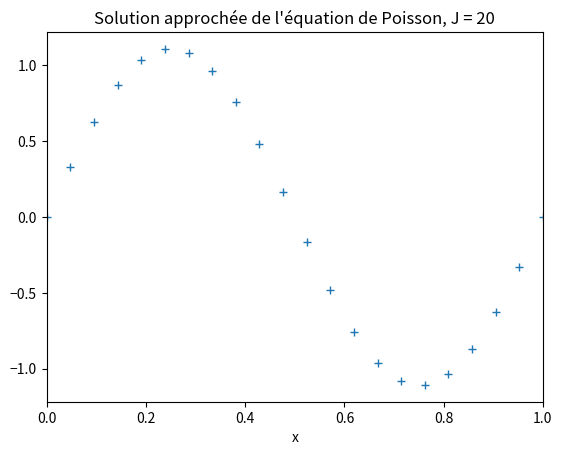

In [27]:
def matrix_poisson(J):
    dx = 1/J
    A = np.diag([2.]*J) + np.diag([-1]*(J-1), k=1) + np.diag([-1]*(J-1), k=-1) 
    A /= dx**2
    return A

def solve_poisson(J, f):
    mesh = np.linspace(0, 1, J+2)
    A = matrix_poisson(J)

    b = f(mesh[1:-1])
    u = np.zeros_like(mesh)
    u[1:-1] = np.linalg.solve(A, b)
    return mesh, u

J = 20
f = lambda x : 4.0 * (np.pi**2.0)*np.sin(2.0*np.pi*x)
mesh, u_fd = solve_poisson(J, f)

plt.plot(mesh, u_fd, '+')
plt.xlim([0,1])
plt.xlabel('x')
plt.title("Solution approchée de l'équation de Poisson, J = "+str(J));

### Partie 1 - Régression

1. Programmer une méthode de régression polynomiale pour interpoler la solution approchée sur un maillage composé de $200$ points. Comparer le résultat obtenu en comparant avec la solution exacte.


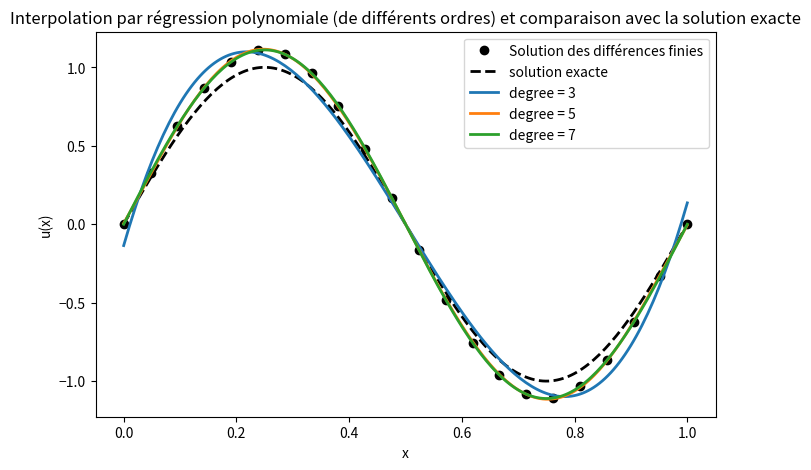

In [28]:
def polynomial_regression(X, Y, degree):
    m = len(X)
    A = np.zeros((m, degree + 1))
    for i in range(degree + 1):
        A[:, i] = X ** i
    theta = np.linalg.solve(A.T @ A, A.T @ Y)
    return theta

mesh_fine = np.linspace(0, 1, 200)
u_exact = np.sin(2*np.pi*mesh_fine)

degrees = [3, 5, 7]

plt.figure(figsize=(8,5))
plt.plot(mesh, u_fd, 'ko', label="Solution des différences finies", markersize=6)
plt.plot(mesh_fine, u_exact, 'k--', label="solution exacte", linewidth=2)

for degree in degrees:
    theta = polynomial_regression(mesh, u_fd, degree)
    A_fine = np.zeros((len(mesh_fine), degree + 1))
    for i in range(degree + 1):
        A_fine[:, i] = mesh_fine ** i
    u_poly = A_fine.dot(theta)
    plt.plot(mesh_fine, u_poly, label="degree = {}".format(degree), linewidth=2)

plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Interpolation par régression polynomiale (de différents ordres) et comparaison avec la solution exacte")
plt.legend()
plt.show()

2. Reprennez la question précédente en utilisant la méthode de régression à noyau avec un noyau radial Gaussien $k(x,y) = \exp(- ||x-y||^2 / (2\ell^2))$.

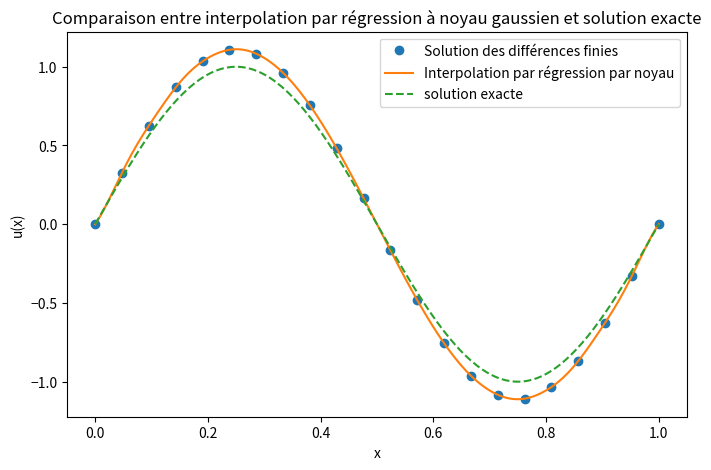

In [29]:
def gaussian_kernel(x, y, ell=0.1):
    return np.exp(-((x - y)**2) / (2 * ell**2))

def kernel_regression(x_train, y_train, x_test, ell=0.1, reg=1e-8):
    N = len(x_train)
    K = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = gaussian_kernel(x_train[i], x_train[j], ell)
    K += reg * np.eye(N)
    alpha = np.linalg.solve(K, y_train)
    
    y_pred = np.zeros_like(x_test)
    for i, x in enumerate(x_test):
        k_vect = np.array([gaussian_kernel(x, xi, ell) for xi in x_train])
        y_pred[i] = k_vect.dot(alpha)
    return y_pred

x_train = mesh
y_train = u_fd
u_kernel = kernel_regression(x_train, y_train, mesh_fine, ell=0.05)

plt.figure(figsize=(8,5))
plt.plot(mesh, u_fd, 'o', label="Solution des différences finies")
plt.plot(mesh_fine, u_kernel, '-', label="Interpolation par régression par noyau")
plt.plot(mesh_fine, u_exact, '--', label="solution exacte")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparaison entre interpolation par régression à noyau gaussien et solution exacte")
plt.legend()
plt.show()

3. Reprenez le même exercice avec un réseau de neurones de type dense (multi-layer perceptron).

In [30]:
class mlp(torch.nn.Module):
    def __init__(self, layer_widths = list):
        super().__init__()

        self.layer_widths = layer_widths
        
        self.hidden_layers = []
        for i in range( len(layer_widths)-1):
            self.hidden_layers.append(torch.nn.Linear(self.layer_widths[i], self.layer_widths[i+1], dtype=torch.double))

        self.hidden_layers = torch.nn.ModuleList(self.hidden_layers)
        self.activation = torch.nn.Tanh()

    def forward(self, inputs):
        for i in range( len(self.layer_widths)-1):
                inputs = self.activation(self.hidden_layers[i].forward(inputs))
        return inputs

In [31]:
class MLP(torch.nn.Module):
    def __init__(self, layer_widths):
        super().__init__()
        layers = []
        for i in range(len(layer_widths)-1):
            layers.append(torch.nn.Linear(layer_widths[i], layer_widths[i+1], dtype=torch.double))
            # 除最后一层外均使用激活函数
            if i < len(layer_widths)-2:
                layers.append(torch.nn.Tanh())
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [32]:
#model = 
#optimizer = torch.optim.Adam(model.parameters())
#nb_epochs = 400

#x_train = 
#y_train = 

#for epoch in range( nb_epochs):
#    optimizer.zero_grad()
#    y_pred = model(x_train)
#    loss = 
#    loss.backward()
#    optimizer.step()

#print("epoch "+ str(epoch)+': '+str(loss.item()))

Epoch 0: loss = 0.605291
Epoch 50: loss = 0.049196
Epoch 100: loss = 0.003360
Epoch 150: loss = 0.002751
Epoch 200: loss = 0.003243
Epoch 250: loss = 0.002724
Epoch 300: loss = 0.004038
Epoch 350: loss = 0.002952


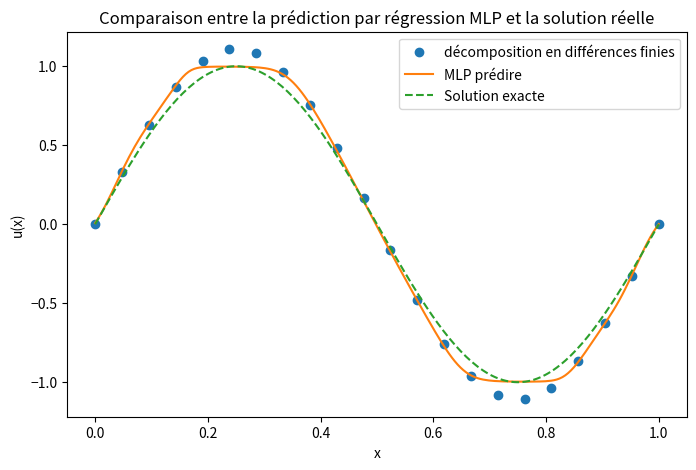

In [33]:
class MLP(torch.nn.Module):
    def __init__(self, layer_widths = list):
        super().__init__()

        self.layer_widths = layer_widths
        
        self.hidden_layers = []
        for i in range( len(layer_widths)-1):
            self.hidden_layers.append(torch.nn.Linear(self.layer_widths[i], self.layer_widths[i+1], dtype=torch.double))

        self.hidden_layers = torch.nn.ModuleList(self.hidden_layers)
        self.activation = torch.nn.Tanh()

    def forward(self, inputs):
        for i in range( len(self.layer_widths)-1):
                inputs = self.activation(self.hidden_layers[i].forward(inputs))
        return inputs

x_train_tensor = torch.tensor(mesh.reshape(-1,1), dtype=torch.double)
y_train_tensor = torch.tensor(u_fd.reshape(-1,1), dtype=torch.double)

model = MLP([1, 50, 50, 50, 50, 50, 1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
nb_epochs = 400

for epoch in range(nb_epochs):
    optimizer.zero_grad()
    y_pred = model(x_train_tensor)
    loss = torch.nn.functional.mse_loss(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print("Epoch {}: loss = {:.6f}".format(epoch, loss.item()))

x_test_tensor = torch.tensor(mesh_fine.reshape(-1,1), dtype=torch.double)
y_test_pred = model(x_test_tensor).detach().numpy().flatten()

plt.figure(figsize=(8,5))
plt.plot(mesh, u_fd, 'o', label="décomposition en différences finies")
plt.plot(mesh_fine, y_test_pred, '-', label="MLP prédire")
plt.plot(mesh_fine, u_exact, '--', label="Solution exacte")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Comparaison entre la prédiction par régression MLP et la solution réelle")
plt.legend()
plt.show()

### Partie 2 - propagation d'incertitudes

Supposons que l'on ne connaisse pas exactement la fonction $f(x)$. Celui peut être modélisé par un processus Gaussien avec un noyau de type radial Gaussien: c'est donc une fonction aléatoire. Par ailleurs, nous l'ajustons de sorte à ce qu'il passe par certaines valeurs ponctuelles $(f_i)_{i=1,\ldots m}$ en certains points $(y_i)_{i=1,\ldots m}$: nous obtenons ainsi une probabilité condtionnelle à cet évènement.

Etant donné cette incertitude sur $f$, on voudrait connaitre celle sur $u$.

1. A l'aide de scikit-learn, ajuster un processus gaussien en supposant qu'il passe par $m$ points $(y_1,\sin(2\pi y_1)+\varepsilon_1),\ldots,(y_m,\sin(2\pi y_m)+\varepsilon_m)$ et afficher le. 

In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


#plt.plot(fine_mesh, mean_prediction, label="Mean prediction")
#plt.fill_between(
#    fine_mesh.ravel(),
#    mean_prediction - 1.96 * std_prediction,
#    mean_prediction + 1.96 * std_prediction,
#    alpha=0.5,
#    label=r"95% confidence interval",
#    );
#plt.legend(loc='best');

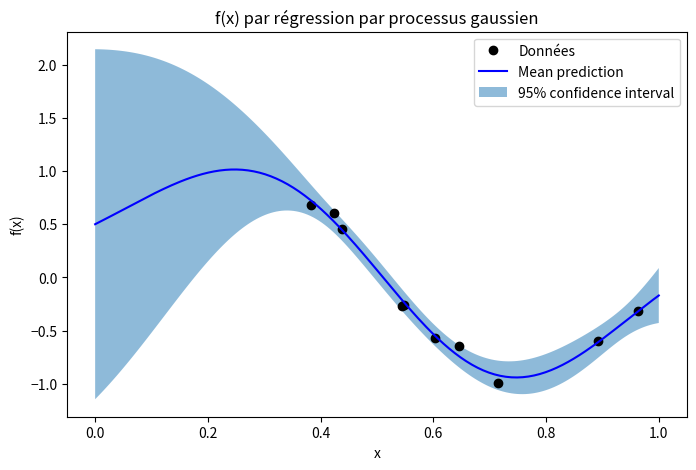

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

m = 10
np.random.seed(0)
y_observed = np.sort(np.random.rand(m))
noise = 0.1 * np.random.randn(m)
f_observed = np.sin(2*np.pi*y_observed) + noise

kernel = RBF(length_scale=0.1)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.01)

X_observed = y_observed.reshape(-1,1)
gp.fit(X_observed, f_observed)

X_fine = mesh_fine.reshape(-1,1)
mean_prediction, std_prediction = gp.predict(X_fine, return_std=True)

plt.figure(figsize=(8,5))
plt.plot(X_observed, f_observed, 'ko', label="Données")
plt.plot(X_fine, mean_prediction, 'b-', label="Mean prediction")
plt.fill_between(X_fine.ravel(),
                 mean_prediction - 1.96 * std_prediction,
                 mean_prediction + 1.96 * std_prediction,
                 alpha=0.5, label="95% confidence interval")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("f(x) par régression par processus gaussien")
plt.legend()
plt.show()

2. A partir de cette loi, échantillonner $n$ seconds membres discrets $(f_i)$ et calculer les solutions approchées associées. 

In [36]:
def solve_poisson_fine(f_values, mesh):
    J = len(mesh) - 2
    dx = mesh[1] - mesh[0]
    A = np.diag([2.0]*J) + np.diag([-1.0]*(J-1), k=1) + np.diag([-1.0]*(J-1), k=-1)
    A /= dx**2
    u = np.zeros_like(mesh)
    u[1:-1] = np.linalg.solve(A, f_values[1:-1])
    return u

n_samples = 50
# gp.sample_y 返回形状为 (len(X_fine), n_samples)，转置后形状为 (n_samples, len(X_fine))
f_samples = gp.sample_y(X_fine, n_samples).T

u_samples = []
for i in range(n_samples):
    u_sample = solve_poisson_fine(f_samples[i], mesh_fine)
    u_samples.append(u_sample)
u_samples = np.array(u_samples)

3. Calculer la moyenne et l'écart type des solutions approchées à l'aide des estimateurs statistiques : 
$$
E[u]=\frac{1}{n}\sum_{i=1}^n\mathbf{u}_i, \quad Var(u)=\frac{1}{n}\sum_{i=1}^n(\mathbf{u}_i-E[u])^2
$$
Afficher ensuite le résultat.

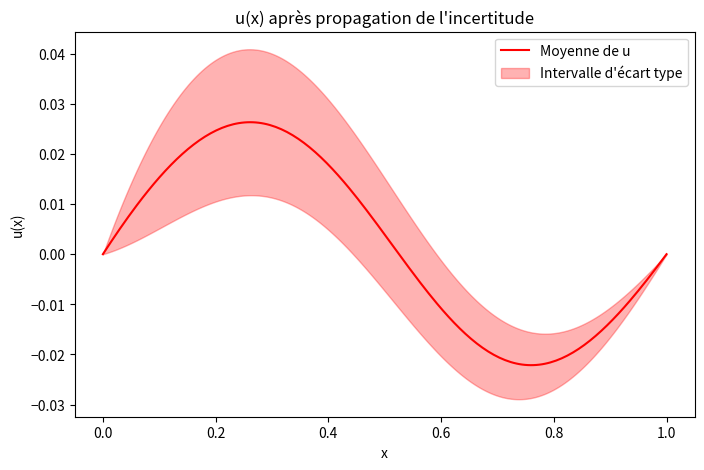

In [37]:
u_mean = np.mean(u_samples, axis=0)
u_std = np.std(u_samples, axis=0)

plt.figure(figsize=(8,5))
plt.plot(mesh_fine, u_mean, 'r-', label="Moyenne de u")
plt.fill_between(mesh_fine, u_mean - u_std, u_mean + u_std, color='r', alpha=0.3, label="Intervalle d'écart type")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("u(x) après propagation de l'incertitude")
plt.legend()
plt.show()